![Human Proteins Atlas](https://user-images.githubusercontent.com/115424463/285138737-dfc99773-a84b-4821-8dd9-1e5c81bfe4d3.jpg)
## [Immune cells data](https://www.proteinatlas.org/humanproteome/immune+cell)

__Hello, fellow Kagglers!__

I have an idea. The thing is, I joined late, so I won't have time to exhaust it.<br>
My concern is that there might be some value for the medical community, both if the assumption is true or strictly false.

`Here is the idea`:

_The task_<br>
We have __cell types__ and __compounds__. The researcher wants to know _what will be the genes expression in reaction to a compound, given a certain type of a cell_.

_The proposal_<br>
Let's consider `cell_type` as a normalization function. We take a vector of genes expression in  response to a particular compound and 'adjust' it based on the specified cell type. After computing this adjustment for each cell type, we normalize each row to a hypothetical "dummy cell" condition, eliminating the "cell type" information from the data. This data structuring puts us in an optimal position for training and prediction using a single predictor — the compound. Subsequently, the forecasted results of the trained model undergo 'restoration' per cell types, producing the final values.

_Why not standard methods_ <br>
__Target-transforming__ algorithms (all kinds tree models, KNN, SVM, etc.) do not capture the functional dependence between `X` and `y`, and do not extend beyond the y_values avaliable in the training data. That's not what a researcher is looking for in this case.

__Feature-transforming__ algorithms (such as LinReg, neural networks) do capture the correlation and non-linear dependencies but demand a substantial amount of data for effective training. In our training set, we have 6 cell types, 146 compounds, and 614 rows (to be precise, 514, as 100 rows contain compounds not used in the test set). This results in 87% of compounds being tested on only 4 cell types (see the plot below). When fitting a curve with just 4 data points, the best achievable outcome is the mean (or some quantile, essentially a guess). While attempting to slightly curve the line with a 2-degree polynomial is possible, it largely relies on chance and does not surpass blending (I experimented with it and wasn't successful). Let's not forget about outliers, noise, multicoliniarity among genes, and other distortions. This is why we end up randomly blending zeros with means and quantiles to get a better score. 

In a nutshell, there is not enough CASES (cell_type x compound) for analytical models to derive meaningful insights from the data. The quantity of additional information about cell_types added to the training set doesn't significantly impact the outcomes. For instance, I included gene expression values per cell_type (options: 'nTPM', 'specificity_score') as extra predictors, but it had no discernible effect (although it might have worked with a larger dataset).

`_REMEDY_`<br>
We have [immune cells data](https://www.proteinatlas.org/humanproteome/immune+cell) from the Human Protein Atlas. It reads that each cell_type is carecterized by a certain expression of leading genes. Does this imply that the type of a cell influences how its genes respond to any given compound? Essentially, this is the core question of the competition.

So, here is the thing. I am not a biologist and I have zero domain knowledge. It takes a knowing person  to harmonize the measuring units from the Human Protein Atlas with the data in this competition. Once that's accomplished, we can normalize the data based on cell_type to a hypothetical `dummy_cell` condition and restore it after making predictions. I believe, this can work.    

_Steps taken_ <br>
As a normalization factor, I tried several options:
- Difference between a gene's global mean expression and cell_type-specific mean expression (all genes)
- The same for the leading genes only (works in the oposite direction)
- Attempted to enhance the training set by incorporating Atlas data for different models.

_Steps to take_
- Bring Atlas and competion's data to the same measuring unites and try the `dummy cell normalization` thing

<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:24px;">
Please upvote if you find my ideas worth consideration <br> 
    </blockquote>

# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

# Data

__Train__:
All compounds in T, NK cells
15 compounds + positive and negative controls in B and myeloid cells

__Test__:
Randomly selected compounds in B and myeloid cells
__Note that there is no additional test data beyond the indicated `cell_type / sm_name pairs`__. The input to your model will be a tuple of cell_type and sm_name and the output of your model will be predicted signed -log10(p-values) for all 18211 genes.

__de_train.parquet__ - Aggregated differential expression data in dense array format.
- genes `A1BG, A1BG-AS1, …, ZZEF1` (numbering __18,211__ in all) - Differential expression value (`-log10(p-value) * sign(LFC)`) for each gene. Here, LFC is the estimated log-fold change in expression between the treatment and control condition after shrinkage as calculated by Limma. Positive LFC means the gene goes up in the treatment condition relative to the control.
- __`cell_type`__ - The annotated cell type of each cell based on RNA expression.
-__`sm_name`__ - The primary name for the (parent) compound (in a standardized representation) as chosen by LINCS. This is provided to map the data in this experiment to the LINCS Connectivity Map data.
sm_lincs_id - The global LINCS ID (parent) compound (in a standardized representation). This is provided to map the data in this experiment to the LINCS Connectivity Map data.
- SMILES - Simplified molecular-input line-entry system (SMILES) representations of the compounds used in the experiment. This is a 1D representation of molecular structure. These SMILES are provided by Cellarity based on the specific compounds ordered for this experiment.


In [3]:
train = pd.read_parquet('/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet')
test = pd.read_csv('/kaggle/input/open-problems-single-cell-perturbations/id_map.csv')

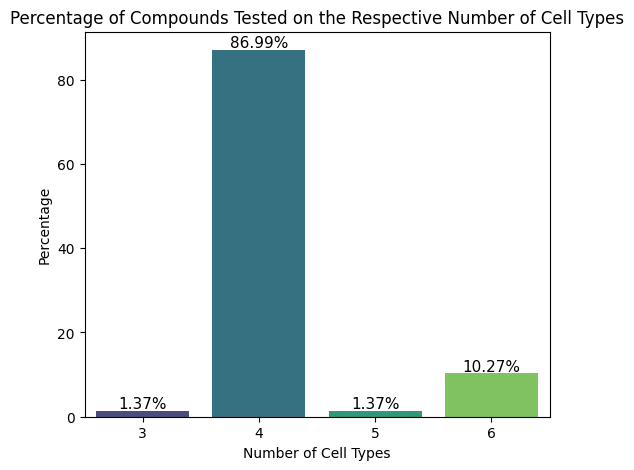

In [4]:
"""
The number of compounds tested on a respective number of unique cell types.
87% are tested on 4 cell types only. 
"""
counts_df = train.groupby('sm_name')['cell_type'].nunique().reset_index(name='cell_type_count')
compounds_counts = counts_df['cell_type_count'].value_counts().sort_index()
compounds_percentages = compounds_counts / len(counts_df) * 100
barplot_df = pd.DataFrame({'Number of Cell Types': compounds_percentages.index,
                           'Percentage of Compounds': compounds_percentages.values})
barplot_df = barplot_df.sort_values(by='Number of Cell Types')

plt.figure(figsize=(6, 5))

ax = sns.barplot(x='Number of Cell Types', y='Percentage of Compounds', data=barplot_df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=11, color='black')

plt.xlabel('Number of Cell Types')
plt.ylabel('Percentage')
plt.title('Percentage of Compounds Tested on the Respective Number of Cell Types')
plt.show()

In [5]:
# train.query('cell_type == "B cells" | cell_type == "Myeloid cells"').shape
print(train.query('cell_type == "B cells" | cell_type == "Myeloid cells"')['sm_name'].nunique())
print(test.query('cell_type == "B cells" | cell_type == "Myeloid cells"')['sm_name'].nunique())

17
129


In [6]:
"""
Comparison
"""
print (f'N compounds in training set {train.sm_name.nunique()}\n'
       f'N compounds in test set {test.sm_name.nunique()}')

N compounds in training set 146
N compounds in test set 129


In [7]:
"""
These compounds are not present in the test set. 
Essentially, this implies that in the training data, 
we have 100 fewer rows when excluding these compounds.
"""
diff = set(train.sm_name.sort_values().unique()) - set(test.sm_name.sort_values().unique())
print (len(train.query('sm_name in @diff')))

100


## Dummy Cell approach

In [8]:
genes = train.columns[5:].to_list()

In [9]:
'''
The leading genes identified for each cell type sourced from the Human Protein Atlas.
Commented are genes that are absent from the competition's data.
'''
expressed_genes = {}

expressed_genes ['NK cells'] = [
#       ('COX6A2',15.0),
#       ('ZMAT4',8.6),
      ('KIR2DL4', 8.0, 80),
      ('APOC2',3.2, 29),
      ('BAALC',3.7, 28),
      ('SERPINE1',9.5, 25),
#       ('NFILZ',14.5),
#       ('EXOC1L',1.9),
      ('RAMP1', 70.4, 18),
      ('LGALS9B',13.3, 17),
#       ('TRIM54',3.6),
#       ('PRDM16',2.4)
]

expressed_genes ['T cells CD4+'] = [
    ('FHIT',87.9, 4),
    ('ADAM23',2.1, 16),
    ('NEFL',11.2, 5)
]

expressed_genes['T cells CD8+'] =[
    ('CFAP97D2',4.0, 13),
    ('CD248',21.9, 7),
#     ('MXRA8',6.4),
#     ('ZCCHC12',1.2),
    ('NRCAM', 2.1, 6),
    ('REG4', 24.7, 6),
    ('SFRP5', 3.6, 4),
    ('MT3', 5.0, 4)
]

expressed_genes ['T regulatory cells'] = [
#     ('ENSG00000290184', 2.0, 17),
    ('FANK1', 61.4, 16),
#     ('SEMA3G', 1.4),
    ('FOXP3', 52.0, 11),
    ('HACD1', 55.9, 11),
#     ('ACTG2', 8.6),
    ('PMCH', 9.6, 10),
#     ('BOLL', 1.5),
    ('TRIM16', 44.9, 9),
#     ('OGN', 1.7),
    ('DUSP4', 6.8, 9),
    ('RTKN2', 16.7, 8)
]

expressed_genes ['B cells'] = [
    ('VPREB3', 807.5, 730),
#     ('ENSG00000275063', 404.4),
#     ('ENSG00000277856', 34.5),
    ('COL19A1', 32.0, 299),
    ('IGLL5', 619.6, 247),
#     ('ENSG00000277836', 17.7),
    ('WNT16', 15.6, 146),
    ('KLHL14', 10.6, 106),
    ('MS4A1', 630.0, 96),
    ('CPNE5', 51.7, 93),
    ('CD19', 172.5, 90),
    ('STEAP1B', 8.4, 85)
]


expressed_genes ['Myeloid cells'] = [
#     ('XCR1', 2.3),
    ('MRC1', 4.8, 16),
    ('CRIP3',44.7, 16),
    ('CD1E',62.6, 14),
    ('HTR7',1.4, 12),
#     ('CD207',1.1),
    ('CLEC10A',466.5, 12),
    ('NDRG2',204.5, 11),
    ('DEPTOR',20.3, 11),
    ('EHF',1.7, 11),
    ('PKIB',34.9, 10),
#     ('C19orf33',22.3)
]

for key in expressed_genes.keys():
    for i in expressed_genes[key]:
        print(f'{i[0]} is in genes: {i[0] in genes}')

KIR2DL4 is in genes: True
APOC2 is in genes: True
BAALC is in genes: True
SERPINE1 is in genes: True
RAMP1 is in genes: True
LGALS9B is in genes: True
FHIT is in genes: True
ADAM23 is in genes: True
NEFL is in genes: True
CFAP97D2 is in genes: True
CD248 is in genes: True
NRCAM is in genes: True
REG4 is in genes: True
SFRP5 is in genes: True
MT3 is in genes: True
FANK1 is in genes: True
FOXP3 is in genes: True
HACD1 is in genes: True
PMCH is in genes: True
TRIM16 is in genes: True
DUSP4 is in genes: True
RTKN2 is in genes: True
VPREB3 is in genes: True
COL19A1 is in genes: True
IGLL5 is in genes: True
WNT16 is in genes: True
KLHL14 is in genes: True
MS4A1 is in genes: True
CPNE5 is in genes: True
CD19 is in genes: True
STEAP1B is in genes: True
MRC1 is in genes: True
CRIP3 is in genes: True
CD1E is in genes: True
HTR7 is in genes: True
CLEC10A is in genes: True
NDRG2 is in genes: True
DEPTOR is in genes: True
EHF is in genes: True
PKIB is in genes: True


In [10]:
'''
Dictionary to DataFrame
'''
expressed_genes_df = pd.DataFrame.from_dict(expressed_genes, orient = 'index')
expressed_genes_df = (expressed_genes_df
                          .stack()
                          .to_frame('genes')
                          .reset_index().drop('level_1', axis=1)
                          .rename({'level_0':'cell_type'}, axis=1)
                         )
expressed_genes_df [['gene', 'nTPM', 'specificity_score']] = expressed_genes_df['genes'].apply(pd.Series)
expressed_genes_df  = expressed_genes_df.drop('genes', axis=1)

expressed_genes_df.head(3)

,cell_type,gene,nTPM,specificity_score
0,NK cells,KIR2DL4,8.0,80
1,NK cells,APOC2,3.2,29
2,NK cells,BAALC,3.7,28


In [11]:
"""
Lables for expressed genes
"""
all_expressed_genes = expressed_genes_df['gene'].unique()
all_expressed_genes_with_suffix = [f'{gene}_exp' for gene in all_expressed_genes]

In [12]:
"""
DataFrame for expressed genes in wide format. nTPM only
"""
expressed = expressed_genes_df.copy().drop('specificity_score', axis=1)
expressed = expressed.set_index(['cell_type', 'gene']).unstack('gene').fillna(0)

expressed.columns = all_expressed_genes_with_suffix
expressed.head(2)

,KIR2DL4_exp,APOC2_exp,BAALC_exp,SERPINE1_exp,RAMP1_exp,LGALS9B_exp,FHIT_exp,ADAM23_exp,NEFL_exp,CFAP97D2_exp,...,STEAP1B_exp,MRC1_exp,CRIP3_exp,CD1E_exp,HTR7_exp,CLEC10A_exp,NDRG2_exp,DEPTOR_exp,EHF_exp,PKIB_exp
cell_type,,,,,,,,,,,,,,,,,,,,,
B cells,0.0,0.0,0.0,172.5,0.0,0.0,0.0,0.0,32.0,51.7,...,0.0,0.0,0.0,0.0,0.0,0.0,8.4,0.0,807.5,15.6
Myeloid cells,0.0,0.0,0.0,0.0,62.6,0.0,0.0,466.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
"""
DataFrame for expressed genes in wide format. 'Specificity score' only
"""
expressed_spc = expressed_genes_df.copy().drop('nTPM', axis=1)
expressed_spc = expressed_spc.set_index(['cell_type', 'gene']).unstack('gene').fillna(0)

expressed_spc.columns = all_expressed_genes_with_suffix
expressed_spc.head(2)

,KIR2DL4_exp,APOC2_exp,BAALC_exp,SERPINE1_exp,RAMP1_exp,LGALS9B_exp,FHIT_exp,ADAM23_exp,NEFL_exp,CFAP97D2_exp,...,STEAP1B_exp,MRC1_exp,CRIP3_exp,CD1E_exp,HTR7_exp,CLEC10A_exp,NDRG2_exp,DEPTOR_exp,EHF_exp,PKIB_exp
cell_type,,,,,,,,,,,,,,,,,,,,,
B cells,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,299.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,85.0,0.0,730.0,146.0
Myeloid cells,0.0,0.0,0.0,0.0,14.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Calculating Normalization Factor 
> as difference between each gene's global average and cell-spesific mean 

In [14]:
cell_specific_mean = train.groupby('cell_type')[genes].mean()
global_avg = train[genes].mean().to_frame().T
norm_factor = (-1) * cell_specific_mean.sub(global_avg.iloc[0], axis=1)
norm_factor.head(3)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
cell_type,,,,,,,,,,,,,,,,,,,,,
B cells,-1.014121,-0.279633,-1.192553,-1.438573,-4.243276,-2.666918,-0.028058,-0.196433,-0.713655,-0.479110,...,-0.186599,-0.515725,-0.198802,-1.172260,-0.455859,-0.198630,-0.396682,-0.356651,0.046357,-0.150454
Myeloid cells,-1.203567,-0.501613,3.005084,-0.732112,-5.974636,-3.088638,-0.442361,-0.055340,-0.186861,-0.648101,...,0.341602,0.262570,1.326535,0.433426,-1.386545,-0.230009,0.824289,0.589025,0.132033,-0.003532
NK cells,-0.050966,-0.158065,0.373067,0.581662,0.401278,-0.378235,-0.049453,-0.056976,0.075260,-0.082430,...,-0.202063,0.273477,-0.001160,0.038941,0.270900,0.015884,0.035667,-0.110394,0.102108,0.024468


In [15]:
"""
Normalization factor for all genes (long format)
"""
norm_factor_long = (norm_factor
                    .stack()
                    .to_frame()
                    .reset_index()
                    .rename({'level_1':'gene', 0:'norm_factor'}, axis=1)
                   )
norm_factor_long.head(4)

,cell_type,gene,norm_factor
0,B cells,A1BG,-1.014121
1,B cells,A1BG-AS1,-0.279633
2,B cells,A2M,-1.192553
3,B cells,A2M-AS1,-1.438573


In [16]:
'''
Normalization factor for expressed genes (wide format)
'''
left_ = expressed_genes_df[['cell_type','gene']]

expressed_genes_norm = (pd.merge(left_, norm_factor_long, how='left')
                      .set_index(['cell_type','gene'])
                      .reset_index(['cell_type','gene'])
                      .pivot(index='cell_type', columns = 'gene')
                      .fillna(0)
                     )
expressed_genes_norm.columns = all_expressed_genes


norm_factor_broad  = pd.DataFrame(0, index = test.set_index(['id','cell_type']).index, columns = genes).reset_index('id')
norm_factor_broad.update(expressed_genes_norm)
norm_factor_broad = norm_factor_broad.reset_index().set_index(['id', 'cell_type'])
norm_factor_broad[all_expressed_genes].head(3)

,,KIR2DL4,APOC2,BAALC,SERPINE1,RAMP1,LGALS9B,FHIT,ADAM23,NEFL,CFAP97D2,...,STEAP1B,MRC1,CRIP3,CD1E,HTR7,CLEC10A,NDRG2,DEPTOR,EHF,PKIB
id,cell_type,,,,,,,,,,,,,,,,,,,,,
0,B cells,0,0,0,3.693106,0.0,0,0,0.0,1.366127,3.521125,...,0,0,0,0,0,0,1.99959,0,2.728957,2.135851
1,B cells,0,0,0,3.693106,0.0,0,0,0.0,1.366127,3.521125,...,0,0,0,0,0,0,1.99959,0,2.728957,2.135851
2,B cells,0,0,0,3.693106,0.0,0,0,0.0,1.366127,3.521125,...,0,0,0,0,0,0,1.99959,0,2.728957,2.135851


# Visualization

In [17]:
left_ = expressed_genes_df[['cell_type','gene']]

right_1 = global_avg.T.reset_index().rename({'index':'gene', 0: "gl_avg"}, axis =1)
viz_data = pd.merge(left_, right_1, on ='gene', how = 'left')

right_2 = cell_specific_mean.stack().to_frame('cell_specific_avg').reset_index().rename({'level_1':'gene'}, axis = 1)
viz_data = pd.merge(viz_data, right_2, on =['cell_type','gene'], how = 'left')

display (viz_data.shape)
viz_data.head(2)

(40, 4)

,cell_type,gene,gl_avg,cell_specific_avg
0,NK cells,KIR2DL4,0.576464,0.129605
1,NK cells,APOC2,0.944148,1.665879


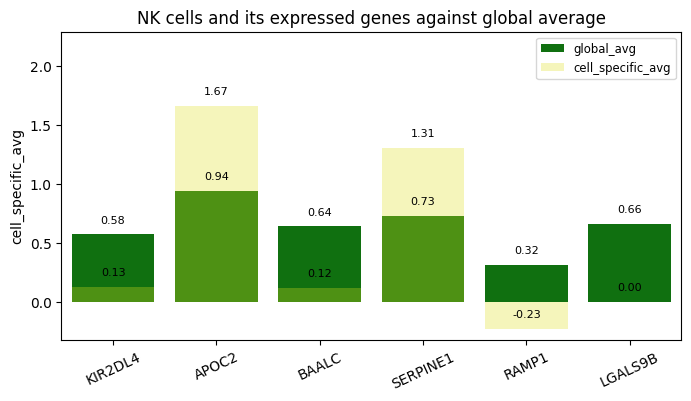

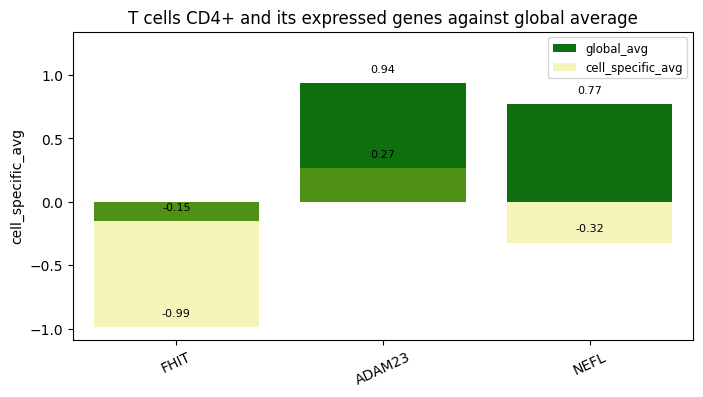

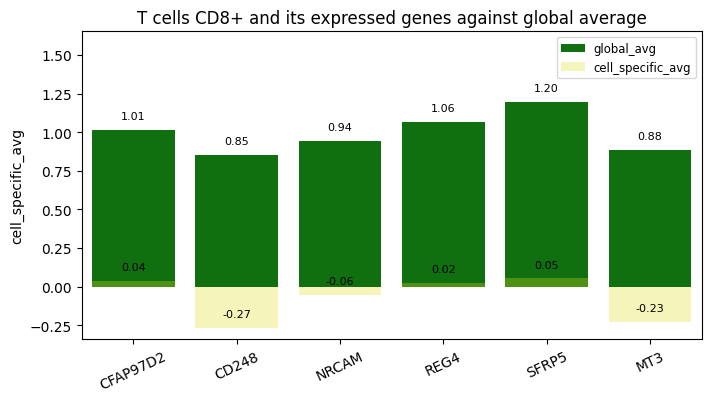

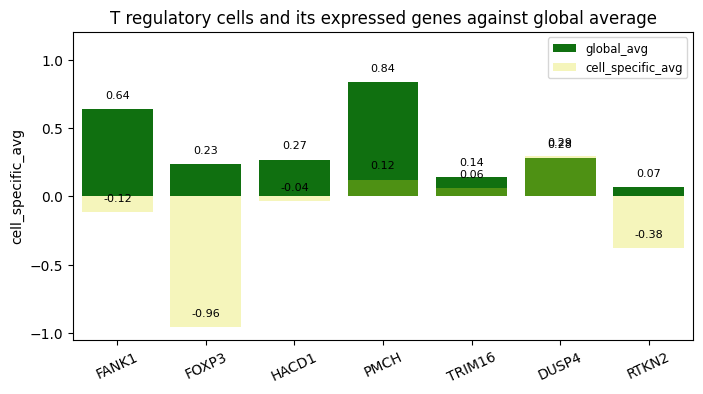

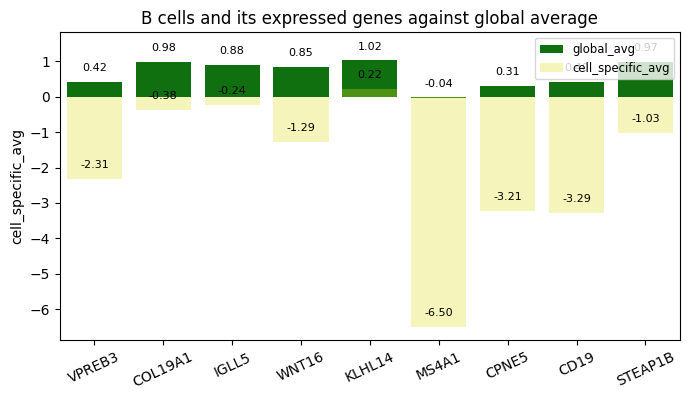

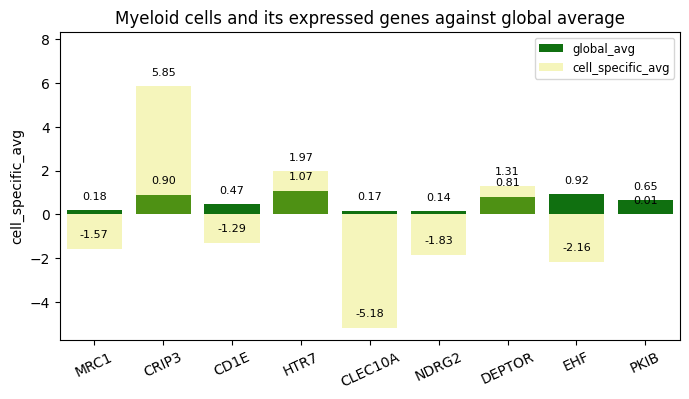

In [18]:
for cell in train['cell_type'].unique():
    plt.figure(figsize=(8, 4))
    plt.xticks(rotation=25)
    plt.title(f'{cell} and its expressed genes against global average')

    data_ = viz_data.query('cell_type == @cell')

    ax = sns.barplot(data_, x='gene', y='gl_avg', color='green', label='global_avg', dodge=True)
    sns.barplot(data_, x='gene', y='cell_specific_avg',color='yellow', label='cell_specific_avg', alpha=0.3, dodge = True, ax=ax)
    ax.legend(loc='upper right', fontsize='small')
    for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8, color='black')
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.3)
#     ax.set_xticklabels([])
    ax.set_xlabel(None)
    plt.show()

# Baseline
> Best blend so far <br>
> Score: 0.567

In [19]:
""" 
The blend
"""
df577 = pd.read_csv('/kaggle/input/open-problems-2-blends/LB0577_ZacharyScheben_blend_SCPblend058_nbV19.csv', index_col='id')
df574 = pd.read_csv('/kaggle/input/testsubmissiondataset/submission.csv', index_col='id')
df = 0.75 * df574 + 0.25 * df577
df[:128] = 0.50 * df574[:128] + 0.50 * df577[:128]
df[128:] = 0.72 * df574[128:] + 0.28 * df577[128:]

df_blend = test[['id','cell_type']].join(df).set_index(['id','cell_type'])

# Scheme_1: Normalization factor to all genes
> Adding  - Score: 1.01 <br>
> Substracting - Score: 0.937

In [20]:
cell_types = norm_factor.index.to_list()
dfs = {}

for cell in cell_types:
    dfs[cell] = df_blend.query('cell_type == @cell')
    dfs[cell] = dfs[cell].add(norm_factor.loc[cell], axis=1)
#     dfs[cell] = dfs[cell].sub(norm_factor.loc[cell], axis=1)

df_final = pd.concat(dfs.values(), axis=0).reset_index(['cell_type'], drop=True)

# df_final.to_csv('submission.csv')
df_final.head(4)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,-0.711702,-0.139207,-0.996695,-0.712961,-3.432625,-2.161161,-0.077111,0.069431,-0.961925,0.008889,...,-0.717812,-0.740090,-0.361296,-0.900990,-0.177541,0.166683,-0.018804,-0.027798,-0.488684,-0.177331
1,-1.075454,-0.258738,-1.127415,-1.405057,-3.948060,-2.319724,-0.058927,-0.056228,-0.567338,-0.398002,...,-0.165821,-0.480059,-0.248977,-1.061673,-0.328588,-0.164955,-0.278753,-0.316403,-0.004034,-0.198693
2,-0.731937,-0.094317,-1.271224,-1.324518,-3.476725,-1.557482,-0.083981,0.045227,-0.530341,-0.369585,...,-0.246980,-0.588165,-0.211182,-0.904195,-0.229465,0.069402,-0.098576,-0.238592,-0.342639,-0.320619
3,-1.111252,-0.170052,-1.082867,-1.305253,-3.998176,-2.481250,-0.082147,-0.017489,-0.644917,-0.340051,...,-0.255941,-0.505470,-0.214969,-1.016173,-0.314029,-0.078647,-0.289452,-0.278693,0.036447,-0.203542


# Scheme_2: Normalization factor to expressed genes only
> Score: 0.568

In [21]:
df_final = df_blend + norm_factor_broad

submission = df_final.reset_index(['cell_type'], drop=True)
# submission.to_csv('submission.csv')

# Scheme_3: Comparizon with 'all zeros' baseline
> Baseline: 0.666 <br>
> Score: 0.667

In [22]:
baseline = pd.read_csv('/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv')

baseline = test[['cell_type']].join(baseline).set_index(['id','cell_type'])

df_final = baseline + norm_factor_broad

submission = df_final.reset_index(['cell_type'], drop=True)
# submission.to_csv('submission.csv')

# Scheme_4: Teaching with expressed genes per cell_type (nTPM)
> Baseline (mean): 0.663 <br>
> Score: 0.92

In [23]:
train_extended = pd.merge(train, expressed, on='cell_type', how='left')
test_extended = pd.merge(test, expressed, on='cell_type', how='left')


model = MultiOutputRegressor(
    CatBoostRegressor(
        cat_features = ['cell_type', 'sm_name'],
        verbose = 0,
        iterations = 200,
        depth = 4,
        learning_rate=0.01,
        loss_function = 'RMSE'
    )
)
# X_train = train_extended [['cell_type', 'sm_name'] + all_expressed_genes_with_suffix]
# y_train = train_extended .loc[:,genes].values

# reducer = TruncatedSVD (n_components = 100, n_iter = 7, random_state = 34)
# y_train_r = reducer.fit_transform(y_train)

# model.fit(X_train, y_train_r)

# X_test = test_extended[['cell_type', 'sm_name']+ all_expressed_genes_with_suffix]
# y_test_r = model.predict(X_test)
# y_test = reducer.inverse_transform(y_test_r)

# df_test = pd.DataFrame(y_test, columns = genes)
# df_test.index.name = 'id'
# df_test.to_csv('submission.csv')

# Scheme_5: Teaching with expressed genes per cell_type (specificity_score)
> Baseline (mean): 0.663 <br>
> Score: 0.832

In [24]:
# train_extended = pd.merge(train, expressed_spc, on='cell_type', how='left')
# test_extended = pd.merge(test, expressed_spc, on='cell_type', how='left')

# X_train = train_extended [['cell_type', 'sm_name'] + all_expressed_genes_with_suffix]
# y_train = train_extended .loc[:,genes].values

# reducer = TruncatedSVD (n_components = 100, n_iter = 7, random_state = 34)
# y_train_r = reducer.fit_transform(y_train)

# model.fit(X_train, y_train_r)

# X_test = test_extended[['cell_type', 'sm_name']+ all_expressed_genes_with_suffix]
# y_test_r = model.predict(X_test)
# y_test = reducer.inverse_transform(y_test_r)

# df_test = pd.DataFrame(y_test, columns = genes)
# df_test.index.name = 'id'
# df_test.to_csv('submission.csv')

# Scheme_6: Teaching with expressed genes per cell_type (specificity_score) with LinReg ()
> Baseline (mean): 0.663 <br>
> Score: 0.779

In [25]:
train_extended = pd.merge(train, expressed, on='cell_type', how='left')
test_extended = pd.merge(test, expressed, on='cell_type', how='left')

X_train = train_extended[['cell_type', 'sm_name'] + all_expressed_genes_with_suffix]
y_train = train_extended.loc[:, genes].values

X_test = test_extended[['cell_type', 'sm_name'] + all_expressed_genes_with_suffix]

categorical_features = ['cell_type', 'sm_name']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
reducer = TruncatedSVD(n_components=100, n_iter=7, random_state=34)
y_train_r = reducer.fit_transform(y_train)

lr = LinearRegression()

lr.fit(X_train_transformed, y_train_r)
X_test_transformed = preprocessor.transform(X_test)
y_test_r = lr.predict(X_test_transformed)
y_test = reducer.inverse_transform(y_test_r)

df_test = pd.DataFrame(y_test, columns=genes)
df_test.index.name = 'id'
# df_test.to_csv('submission.csv')

# Scheme_7: Teaching with expressed genes per cell_type (specificity_score) with LinReg() and 2-degree polinomial

> Baseline (mean): 0.663 <br>
> Score: 0.784

In [26]:
train_extended = pd.merge(train, expressed, on='cell_type', how='left')
test_extended = pd.merge(test, expressed, on='cell_type', how='left')

X_train = train_extended[['cell_type', 'sm_name'] + all_expressed_genes_with_suffix]
y_train = train_extended.loc[:, genes].values

X_test = test_extended[['cell_type', 'sm_name'] + all_expressed_genes_with_suffix]

categorical_features = ['cell_type', 'sm_name']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)

poly = PolynomialFeatures(degree=2)
X_train_transformed_poly = poly.fit_transform(X_train_transformed)

reducer = TruncatedSVD(n_components=100, n_iter=7, random_state=34)
y_train_r = reducer.fit_transform(y_train)

lr = LinearRegression()

lr.fit(X_train_transformed_poly, y_train_r)

X_test_transformed = preprocessor.transform(X_test)

# Adding polynomial features (quadratic)
X_test_transformed_poly = poly.transform(X_test_transformed)

y_test_r = lr.predict(X_test_transformed_poly)
y_test = reducer.inverse_transform(y_test_r)

df_test = pd.DataFrame(y_test, columns=genes)
df_test.index.name = 'id'
df_test.to_csv('submission.csv')

<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:24px;">
Please upvote if you find my ideas worth consideration <br> 
    </blockquote>